In [1]:
%matplotlib inline
from pathlib import Path
import seaborn as sns
from fastai.text import *
from fastai import __version__

In [2]:
print("Python version: {}". format(sys.version))
print("seaborn version: {}". format(sns.__version__))
print("fastai version: {}". format(__version__))

Python version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
seaborn version: 0.9.0
fastai version: 1.0.55


# Preparando os dados

In [3]:
# setando o path para os dados
path = Path('./data')

In [0]:
df = pd.read_csv(path/'treinamento.csv', encoding = 'ISO-8859-1')

In [0]:
df.shape

(2864, 2)

In [0]:
df.isnull().sum()

mensagem     0
categoria    0
dtype: int64

In [0]:
df.head()

,mensagem,categoria
0,"""192.168.1.3:1521:f3ipro"" ""192.168.1.3:1521:f3...",outros
1,Obrigado pela atenção. Atendimento nota dez. V...,elogio
2,Absurdo. Devolveram meu cheque sem me consulta...,reclamação
3,Se eu não fizer isso não poderei receber? Poss...,informação
4,Eu consigo cancelar ?,informação


In [0]:
df['categoria'].value_counts()

outros        955
informação    791
reclamação    773
elogio        345
Name: categoria, dtype: int64

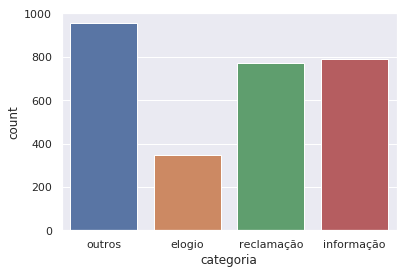

In [0]:
sns.set(style="darkgrid")
ax = sns.countplot(x="categoria", data=df)
plt.show()

In [0]:
df.to_csv(path/'treinamento_utf-8.csv', encoding = 'utf-8')

### Criação de um objeto "Databunch" para realizar "Tokenization" e "Numericalization" dos dados.

In [0]:
data = TextDataBunch.from_csv(path, 'treinamento_utf-8.csv', text_cols='mensagem', label_cols='categoria')

### Tokenization

In [0]:
data.show_batch()

text,target
"xxbos xxmaj fiz um saque na minha conta corrente dia 28 / 03 . 10 000 rupias . nao no cartao de credito . xxmaj sim ha um credito na fatura , mas o valor do saque esta sendo xxunk . o valor da fatura xxunk dolares nao bate com o valor das minhas compras . xxmaj minhas compras no exterior : $ xxunk 22 / 03 $ xxunk 25",reclamação
"xxbos xxmaj xxunk ) , xxmaj eu fiz o upgrade numa agência do banco do xxmaj brasil a 20 dias atrás ! xxmaj fiz na agência do xxmaj bom xxmaj jesus do xxmaj tocantins - xxup xxunk ! xxmaj eu estava no xxmaj brasil e xxunk para fazer levar os documentos , foram todos xxunk e a informação que recebi é que em 30 dias ia chegar o cartão da",informação
xxbos xxmaj pela segunda vez me ofereceram um xxunk capital de giro e para investimento . xxmaj xxunk o faturamento da empresa . xxmaj tenho 6 clinicas de xxunk e mandei de uma delas com faturamento xxunk de xxunk mil reais por ano e me ofereceram um capital de giro de xxunk reais . xxmaj ano passado xxunk 2 xxunk para outras clinicas que xxunk xxunk xxunk mil reais e,reclamação
"xxbos olá tenho um novo problema : xxmaj houve uma compra que eu não reconheço na fatura do cartão e pedi contestação , na qual fui atendido em parte . xxmaj em parte porque xxunk apenas a xxunk parcela e a compra que não reconheço foi feita em duas parcelas . o banco não estornou a 2ª parcela e pelo telefone xxunk 0001 não pude resolver esse problema . xxmaj",informação
"xxbos xxmaj bom dia ! xxmaj fiquei muito feliz por conseguir financiamento imobiliário no xxup bb . xxmaj porém , algo me deixou um pouco xxunk , apesar de ter assinado tantos documentos não fiquei com a xxunk e como havia xxunk p / xxunk achei que a cobrança seria a partir do mês 04 / xxunk em fim eu xxunk . xxmaj ai , como a cobrança foi a",reclamação


In [0]:
data.train_ds[0][0]

Text xxbos xxmaj imposto poupança

### Numericalization

In [0]:
data.vocab.itos[:18]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 ',',
 'de',
 'o',
 'e',
 'a',
 'que',
 'com',
 'do']

In [0]:
data.train_ds[0][0].data[:10]

array([  2,   5, 466, 142])

# Modelo de Linguagem

In [5]:
bs=48

In [0]:
tokenizer = Tokenizer(SpacyTokenizer, 'pt')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=30000)]

### Criando o DataBunch 

In [0]:
data_lm = (TextList.from_csv(path, 'treinamento_utf-8.csv', cols='mensagem', processor=processor)           
            .split_by_rand_pct(0.1, seed=50)       #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()               #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [6]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [10]:
data_lm.show_batch()

idx,text
0,", xxunk , xxmaj xxunk xxmaj xxunk da xxmaj silva xxbos fala com uma pessoa xxbos xxmaj cpf xxunk xxmaj xxunk xxmaj xxunk da xxmaj silva xxmaj xxunk xxunk / xxunk xxbos xxmaj quero agradecer o seu grande profissionalismo ... e sua xxunk e xxunk ajuda . xxmaj vc fez uma grande xxunk na minha xxunk junto a o xxup bb xxbos xxmaj estou chateada pois o dinheiro xxunk ela"
1,e simplesmente xxup nao xxbos xxmaj muito legal esse aplicativo do xxup bb xxbos xxmaj olá gostaria muito de saber a dívida que tenho com vocês pra xxunk xxbos conta digital xxbos conta facil xxbos xxmaj e-mail de vocês xxbos xxmaj xxunk xxmaj francisco xxunk xxbos xxmaj perfeito . xxmaj agradeço . xxbos xxunk xxunk xxbos xxmaj preciso fazer um xxunk para pagar meu cartão de crédito xxbos 05 /
2,"o atendimento xxbos como funciona o consorcio xxbos sou xxunk do banco xxbos xxmaj banco do xxmaj brasil e uma merda ! xxmaj vou xxunk de movimentar aí transferir xxmaj bradesco vou deixar só o dinheiro do crédito imobiliário xxbos xxunk xxbos xxmaj eu xxunk o meu banco . xxbos consorcio de servicos xxbos xxmaj gostaria de um atendimento humano aqui xxbos xxmaj xxunk mas , como cliente , estou"
3,"parabens rafael , se puder registrar os elogios fico feliz . xxmaj atendimento xxunk e xxunk muito bom . xxmaj está de parabens . xxbos como xxunk para pedi meu cartão pelo aplicativo xxbos xxmaj não consigo pagar um boleto ! xxbos xxmaj estou muito estressado e nao xxunk isso . xxmaj amanhã será o xxunk dia . xxbos é uma proposta quase xxunk que xxunk o xxunk da xxup"
4,"! xxbos xxmaj boa noite ! xxbos xxmaj muito obrigado xxbos servicos xxbos xxmaj primeiramente , não tenho tempo de ir em uma agência mais próxima de minha casa , então preciso está xxunk sobre algumas dúvidas . xxbos xxmaj já estou chateada com vocês . xxmaj até hoje não xxunk os meus xxunk xxunk o seguro de meu carro . xxbos xxmaj xxunk . xxmaj queria te agradecer ,"


### Criando o modelo de linguagem

A partir de um modelo de linguagem "pré-treinado", será criado um modelo customizado para as mensagens.

In [0]:
# Nomes dos arquivos de modelo e vocabulário pré-treinado
pretrained_fnames = ('lm_Pt_Br_30kt_ft', 'itos')
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretrained_fnames, drop_mult=0.3)

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


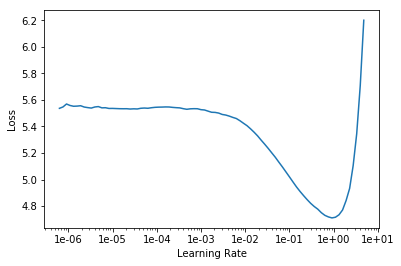

In [13]:
learn.recorder.plot(skip_end=3)

### Treinando o modelo 

In [14]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.348054,3.637704,0.280060,00:03


In [0]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.264577,3.425747,0.312500,00:04
1,3.071684,3.338325,0.327083,00:04
2,2.844194,3.219600,0.358036,00:04
3,2.532441,3.205122,0.384226,00:04
4,2.192487,3.248363,0.400149,00:04
5,1.883318,3.306561,0.399702,00:04
6,1.613788,3.356941,0.407441,00:04
7,1.398223,3.353197,0.406101,00:04
8,1.231157,3.368752,0.408482,00:04
9,1.100690,3.365639,0.406101,00:04


In [0]:
learn.save('lm_reviews_ft')

In [0]:
learn.load('lm_reviews_ft');

### Testando o modelo

Testando as previsões realizadas pelo modelo de próximas palavras de um texto inserido.

In [0]:
TEXT = "Depois de realizar"
N_WORDS = 18

In [22]:
learn.predict(TEXT, N_WORDS, temperature=0.75)

'Depois de realizar a alteração na Conta Corrente , Ma . xxbos Preciso falar com um atendente'

### Salvando o encoder para utilização no classificador

In [0]:
learn.save_encoder('lm_reviews_ft_enc')

# Classificador

In [0]:
bs=48

In [0]:
tokenizer = Tokenizer(SpacyTokenizer, 'pt')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=30000)]

In [0]:
data_clas = (TextList.from_csv(path, 'treinamento_utf-8.csv', cols='mensagem', vocab=data_lm.vocab, processor=processor)           
            .split_by_rand_pct(0.1, seed=50)       #Dividindo randomicamente o dataset em 10% para validação
            .label_from_df(cols='categoria')       #Setando a coluna de label 
            .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [7]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [79]:
data_clas.show_batch()

text,target
"xxbos xxmaj bom dia . xxmaj gostaria de obter a informação xxunk , pois cada vez a atendente no xxup bb da agencia xxunk , da xxmaj xxunk xxmaj xxunk xxmaj lima , diz uma coisa diferente . xxmaj estou xxunk fora do xxmaj brasil , e preciso dos extratos do segundo xxunk dos anos xxunk , 13 e 14 da conta corrente xxunk xxunk da minha empresa , xxmaj",informação
xxbos xxmaj pela segunda vez me ofereceram um fco capital de giro e para investimento . xxmaj solicitaram o faturamento da empresa . xxmaj tenho 6 clinicas de radiologia e mandei de uma d elas com faturamento contabil de 900 mil reais por ano e me ofereceram um capital de giro de 15mil reais . xxmaj ano passado compramos 2 equipamentos para outras clinicas que juntos somaram 500 mil reais,informação
xxbos xxmaj pela segunda vez me ofereceram um fco capital de giro e para investimento . xxmaj solicitaram o faturamento da empresa . xxmaj tenho 6 clinicas de radiologia e mandei de uma d elas com faturamento contabil de 900 mil reais por ano e me ofereceram um capital de giro de 15mil reais . xxmaj ano passado compramos 2 equipamentos para outras clinicas que juntos somaram 500 mil reais,informação
"xxbos xxmaj fiz um saque na minha conta corrente dia 28 / 03 . e nao no cartao de credito . xxmaj sim ha um credito na fatura , mas quando xxunk o valor total nao bate com as compras que fiz . o valor da fatura 277 dolares nao bate com o valor das minhas compras ( esta xxunk o saque xxunk ? ) xxmaj minhas compras no exterior",informação
"xxbos xxmaj xxunk ) , xxmaj eu fiz o xxunk xxunk agência do banco do xxmaj brasil a 20 dias atrás ! xxmaj fiz na agência do xxmaj bom xxmaj jesus do xxunk ! xxmaj eu estava no xxmaj brasil e xxunk para fazer levar os documentos , foram todos xxunk e a informação que recebi é que em 30 dias ia xxunk o cartão da conta corrente . é",informação


### Criando o modelo

Criando o modelo para classificação das mensagens e carregando o encoder salvo anteriormente.

In [39]:
wgts_fname = path/'models'/'lm_Pt_Br_30kt_ft.pth'
itos_fname = path/'models'/'itos.pkl'

model = get_text_classifier(AWD_LSTM, len(data_clas.vocab.itos), data_clas.c, drop_mult=0.5)
learn = RNNLearner(data_clas, model, split_func=awd_lstm_clas_split) 
learn.load_pretrained(wgts_fname, itos_fname, strict=False)
learn.freeze()

In [40]:
learn.load_encoder('lm_reviews_ft_enc')

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


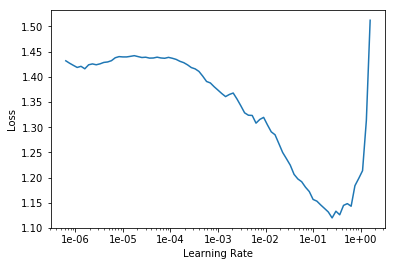

In [21]:
learn.recorder.plot()

In [22]:
lr=2e-2
lr *= bs/48

### Treinando o modelo

In [23]:
learn.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.833085,0.378235,0.849650,00:49
1,0.736656,0.404634,0.835664,00:48


In [24]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.648618,0.320185,0.884615,01:25
1,0.523523,0.303552,0.891608,01:34


In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.456644,0.304044,0.891608,02:56
1,0.386445,0.295128,0.902098,02:46


In [42]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.314183,0.304170,0.912587,04:20


#### Salvando o modelo com acurácia de 91%.

In [43]:
learn.save('clas_reviews_ft')

### Testando o modelo 

Testando a classificação realizada pelo modelo de uma mensagem inserida. 

In [48]:
learn.predict("O atendimento foi muito bom")

(Category elogio, tensor(0), tensor([0.5652, 0.0222, 0.0947, 0.3178]))